# 240923.ver


In [42]:
from konlpy.tag import Okt
import re
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from itertools import zip_longest
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from tqdm import tqdm
import pickle
import glob
from datetime import datetime, timedelta


In [57]:
def load_stopwords(file_path):
    """
    file_path 경로에서 불용어를 불러오는 함수
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines()
    return stopwords


# def preprocess_text_with_ngrams(text, stopwords=None, n=2):
#     """
#     Okt를 사용한 텍스트 전처리 함수 (n-gram 포함)
#     - 불용어 제거
#     - 명사 추출 및 n-gram 생성
#     """
#     okt = Okt()
#     text = re.sub(r'\d+', '', text)  # 숫자 제거
#     text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    
#     nouns = okt.nouns(text)
    
#     if stopwords:
#         nouns = [word for word in nouns if word not in stopwords]
    
#     # n-gram 생성
#     ngrams = zip_longest(*[nouns[i:] for i in range(n)])
#     ngram_list = [' '.join(filter(None, ngram)) for ngram in ngrams]
    
#     return ngram_list


def preprocess_text(text, stopwords=None):
    """
    Okt를 사용한 텍스트 전처리 함수
    - 불용어 제거
    - 명사 추출
    """
    okt = Okt()
    # 정규 표현식을 사용한 숫자/특수문자 제거
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    nouns = okt.nouns(text)

    if stopwords:
        nouns = [word for word in nouns if word not in stopwords]
    
    # 길이가 1인 단어들 제거
    nouns = [word for word in nouns if len(word) > 1]

    processed_text = ' '.join(nouns)

    return processed_text


def load_and_merge_section_data(section_number, hours_back=9):
    """
    섹션 번호에 해당하는 모든 pkl 파일을 불러와서 기사 본문을 하나의 변수로 병합하는 함수
    현재 시간에서 -hours_back 시간 전까지의 파일만 병합
    """
    current_time = datetime.now()
    start_time = current_time - timedelta(hours=hours_back)

    valid_hours = []
    for hour in range(hours_back + 1): # 0부터 hours_back까지의 시간을 계산
        valid_hour = (start_time + timedelta(hours=hour)).strftime('%H')
        valid_hours.append(valid_hour)

    file_patterns = [f"./data/{section_number}/*_{hour}.pkl" for hour in valid_hours]

    merged_content = []
    for file_pattern in tqdm(file_patterns, desc=f"섹션 번호: {section_number} 파일"):
        file_list = glob.glob(file_pattern)

        for file_path in file_list:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                for article in data:
                    merged_content.append(article['content'])

    merged_document = ' '.join(merged_content)

    return merged_document


def process_sections(section_numbers, stopwords_file_path, hours_back=9):
    """
    주어진 섹션 번호 리스트에 대해 각 섹션별로 데이터를 병합하고 전처리하는 함수
    """
    # 불용어 로드
    print("불용어를 불러오는 중입니다...")
    stopwords = load_stopwords(stopwords_file_path)

    processed_documents = {}

    for section_number in tqdm(section_numbers, desc="섹션 처리중"):
        # 데이터 병합
        merged_content = load_and_merge_section_data(section_number, hours_back)

        # 텍스트 전처리
        print(f"{section_number}번 텍스트 전처리 중...")
        processed_text = preprocess_text(merged_content, stopwords)

        # 섹션 번호를 키로 하여 전처리된 문서를 저장
        processed_documents[section_number] = processed_text

    return processed_documents

# def process_sections_with_ngrams(section_numbers, stopwords_file_path, hours_back=9, n=2):
#     """
#     주어진 섹션 번호 리스트에 대해 각 섹션별로 데이터를 병합하고 전처리하는 함수
#     - n: n-gram 크기, 기본값은 2
#     """
#     stopwords = load_stopwords(stopwords_file_path)
#     processed_documents = {}

#     for section_number in tqdm(section_numbers, desc="섹션 처리중"):
#         merged_content = load_and_merge_section_data(section_number, hours_back)
#         processed_text = preprocess_text_with_ngrams(merged_content, stopwords, n)
#         processed_documents[section_number] = processed_text

#     return processed_documents



def prepare_data_for_lda(doc):
    """
    LDA를 위한 데이터를 준비하는 함수
    - doc: 전처리된 텍스트 데이터 (단일 섹션의 텍스트)
    """
    # 전처리된 문서를 리스트로 변환
    text = doc.split()

    # 딕셔너리 생성
    dictionary = corpora.Dictionary([text])

    # 코퍼스 생성(단어의 빈도수로 변환된 텍스트 데이터)
    corpus = [dictionary.doc2bow(text)]

    return dictionary, corpus


# def prepare_data_for_lda(doc):
#     """
#     LDA를 위한 데이터를 준비하는 함수
#     - doc: 전처리된 텍스트 데이터 (단일 섹션의 텍스트)
#     """
#     dictionary = corpora.Dictionary([doc])
#     corpus = [dictionary.doc2bow(doc)]
#     return dictionary, corpus

def train_lda_model(dictionary, corpus, num_topics=5, passes=15):
    """
    LDA 모델을 학습하는 함수
    - dictionary: Gensim의 Dictionary 객체
    - corpus: Gensim의 코퍼스 객체
    - num_topics: 생성할 토픽의 수
    - passes: 학습 반복 횟수
    """
    # LDA 모델 학습
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         update_every=1,
                         passes=passes,
                         alpha='auto',
                         per_word_topics=True)
    
    return lda_model


def extract_topics_for_section(processed_docs, num_topics=1, num_words=10, passes=15):
    """
    각 섹션별로 토픽을 추출하는 함수
    - processed_docs: 전처리된 텍스트 데이터 (딕셔너리 형태, 섹션별로 저장됨)
    - num_topics: 생성할 토픽의 수
    - num_words: 각 토픽에 대해 출력할 단어 수
    - passes: 학습 반복 횟수
    """
    section_topics = {}

    for section, doc in tqdm(processed_docs.items(), desc="각 섹션별로 토픽을 추출합니다."):
        # 데이터 준비
        dictionary, corpus = prepare_data_for_lda(doc)

        # LDA 모델 학습
        lda_model = train_lda_model(dictionary, corpus, num_topics=num_topics, passes=passes)

        # 토픽 추출
        topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
        section_topics[section] = topics

    return section_topics


# def extract_topics_for_section(processed_docs, num_topics=1, num_words=10, passes=15):
#     section_topics = {}
#     lda_models = {}

#     for section, doc in tqdm(processed_docs.items(), desc="각 섹션별로 토픽을 추출합니다."):
#         dictionary, corpus = prepare_data_for_lda(doc)
#         lda_model = train_lda_model(dictionary, corpus, num_topics=num_topics, passes=passes)
#         topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
#         section_topics[section] = topics
#         lda_models[section] = lda_model

#     return section_topics, lda_models



def print_section_topics(section_topics, num_words=10):
    """
    각 섹션별로 추출된 토픽을 출력하는 함수
    - section_topics: 섹션별로 학습된 토픽 데이터
    - num_words: 각 토픽에 대해 출력할 단어 수
    """
    for section, topics in section_topics.items():
        print(f"\nSection {section} Topics:")
        for i, topic in enumerate(topics):
            topic_words = [word for word, _ in topic[1]]  # topic[1]이 단어-가중치 리스트임
            print(f"  Topic {i}: {', '.join(topic_words[:num_words])}")


def create_word_cloud_with_frequency(lda_model, topic_num):
    """
    특정 토픽에 대해 워드 클라우드를 생성하고, 각 단어의 빈도수를 출력하는 함수
    - lda_model: 학습된 LDA 모델
    - topic_num: 워드 클라우드를 생성할 토픽 번호
    """
    # 토픽 내 단어와 가중치 추출
    topic_words = dict(lda_model.show_topic(topic_num, topn=30)) # 상위 30개 단어
    # font_path 확인 필요
    wordcloud = WordCloud(font_path='./data/NanumGothic.ttf', background_color='white').generate_from_frequencies(topic_words)

    # 워드 클라우드 시각화
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    # 각 단어와 빈도수 출력
    print(f"토픽 {topic_num}의 단어 가중치(빈도수):")
    for word, freq in topic_words.items():
        print(f"{word}: {freq}")




In [58]:
# 사용 예시
section_numbers = [100, 101, 102, 103, 104, 105]
stopwords_file_path = './data/korean_stopwords.txt'
processed_docs = process_sections(section_numbers, stopwords_file_path)

section_topics = extract_topics_for_section(processed_docs, num_topics=3, num_words=10, passes=15)
print_section_topics(section_topics)

불용어를 불러오는 중입니다...


섹션 번호: 100 파일: 100%|██████████| 10/10 [00:00<00:00, 4899.32it/s]

100번 텍스트 전처리 중...



섹션 번호: 101 파일: 100%|██████████| 10/10 [00:00<?, ?it/s]


101번 텍스트 전처리 중...


섹션 번호: 102 파일: 100%|██████████| 10/10 [00:00<?, ?it/s]


102번 텍스트 전처리 중...


섹션 번호: 103 파일: 100%|██████████| 10/10 [00:00<?, ?it/s]


103번 텍스트 전처리 중...


섹션 번호: 104 파일: 100%|██████████| 10/10 [00:00<?, ?it/s]


104번 텍스트 전처리 중...


섹션 처리중: 100%|██████████| 6/6 [00:05<00:00,  1.36it/s]

105번 텍스트 전처리 중...


각 섹션별로 토픽을 추출합니다.: 100%|██████████| 6/6 [00:00<00:00,  8.93it/s]


Section 100 Topics:
  Topic 0: 대통령, 김우영, 여사, 국민, 체코, 의원, 윤석열, 민주당, 원전, 김건희
  Topic 1: 대통령, 김우영, 체코, 의원, 여사, 국민, 원전, 대표, 윤석열, 문제
  Topic 2: 대통령, 김우영, 체코, 여사, 국민, 의원, 대표, 김건희, 지금, 민주당

Section 101 Topics:
  Topic 0: 금리, 반도체, 시장, 투자, 미국, 주가, 증권, 지난, 상승, 대한
  Topic 1: 시장, 금리, 투자, 반도체, 인하, 고려아연, 미국, 분석, 하이닉스, 모건스탠리
  Topic 2: 금리, 시장, 투자, 반도체, 인하, 미국, 상승, 지수, 하이닉스, 주가

Section 102 Topics:
  Topic 0: 경찰, 철도, 선생님, 신고, 사진, 학생, 서울, 기자, 혐의, 한국
  Topic 1: 경찰, 지난, 남성, 철도, 혐의, 선생님, 사진, 한국, 서울, 학생
  Topic 2: 경찰, 남성, 철도, 한국, 서울, 지난, 신고, 혐의, 선생님, 대해

Section 103 Topics:
  Topic 0: 로봇, 취소, 효과, 사람, 사진, 지역, 버섯, 제주, 도움, 미국
  Topic 1: 지역, 로봇, 취소, 때문, 효과, 사진, 섭취, 사람, 도움, 정도
  Topic 2: 로봇, 취소, 지역, 사람, 도움, 효과, 제주, 섭취, 때문, 사진

Section 104 Topics:
  Topic 0: 미국, 해리스, 대통령, 대선, 금리, 이스라엘, 트럼프, 후보, 부통령, 달러
  Topic 1: 대통령, 미국, 해리스, 달러, 금리, 이스라엘, 부통령, 트럼프, 후보, 대선
  Topic 2: 대통령, 미국, 해리스, 달러, 트럼프, 이스라엘, 부통령, 금리, 대선, 후보

Section 105 Topics:
  Topic 0: 시장, 애플, 중국, 아이폰, 분석, 시리즈, 판매량, 게임, 코로나바이러스, 야생동물
  Topic 1: 애플, 중국, 

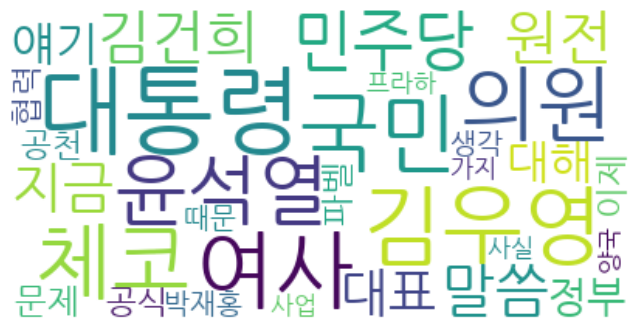

토픽 0의 단어 가중치(빈도수):
대통령: 0.0006646430119872093
김우영: 0.0005425470299087465
여사: 0.0005230933893471956
국민: 0.0005189415533095598
체코: 0.0005079433904029429
의원: 0.000496421882417053
윤석열: 0.00048546228208579123
민주당: 0.00048452182090841234
원전: 0.00048447592416778207
김건희: 0.00048257250455208123
말씀: 0.000482488248962909
지금: 0.0004820473550353199
대표: 0.0004798079316969961
얘기: 0.00047470448771491647
대해: 0.00046989874681457877
정부: 0.0004676962271332741
문제: 0.0004644709115382284
파벨: 0.00046446817577816546
이제: 0.00046380909043364227
공식: 0.00046219874639064074
공천: 0.00045989302452653646
협력: 0.00045784347457811236
박재홍: 0.00045694177970290184
생각: 0.00045222212793305516
때문: 0.0004522032686509192
프라하: 0.0004516679036896676
가지: 0.00045047901221551
양국: 0.0004502873634919524
사실: 0.0004502668743953109
사업: 0.0004494961758609861


In [59]:
# 첫 번째 섹션 데이터를 LDA 모델에 적합하게 준비
dictionary, corpus = prepare_data_for_lda(processed_docs[100])  # 100번 섹션을 예시로 사용

# LDA 모델 학습
lda_model = train_lda_model(dictionary, corpus, num_topics=3, passes=15)

# 예시: 첫 번째 토픽에 대한 워드 클라우드 생성 및 단어 가중치(빈도수) 출력
create_word_cloud_with_frequency(lda_model, topic_num=0)

# Topic Labeling

In [48]:
# from konlpy.tag import Okt
# import re
# from itertools import chain, tee, islice

# def preprocess_text_with_ngrams(text, stopwords=None, n=2):
#     """
#     Okt를 사용한 텍스트 전처리 함수 (n-gram 포함)
#     - 불용어 제거
#     - 명사 추출 및 n-gram 생성
#     """
#     okt = Okt()
#     text = re.sub(r'\d+', '', text)  # 숫자 제거
#     text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    
#     nouns = okt.nouns(text)
    
#     if stopwords:
#         nouns = [word for word in nouns if word not in stopwords]
    
#     # n-gram 생성
#     ngrams = zip(*[nouns[i:] for i in range(n)])
#     ngram_list = [' '.join(ngram) for ngram in ngrams]
    
#     return ngram_list

# # 예시
# text = "인공지능 기술이 경제에 미치는 영향이 크다. 인공지능은 다양한 분야에서 응용되고 있다."
# stopwords = ["이", "에", "가", "에서"]  # 예시 불용어
# processed_ngrams = preprocess_text_with_ngrams(text, stopwords, n=2)
# print(processed_ngrams)


In [53]:
# def compute_relevance_with_ngrams(lda_model, topic_num, dictionary, lambda_=0.6, top_n=20):
#     topic = lda_model.get_topic_terms(topic_num, topn=top_n)
#     term_frequency = dictionary.dfs
#     total_term_count = sum(term_frequency.values())

#     relevance_scores = []
#     for word_id, prob in topic:
#         term_freq = term_frequency[word_id]
#         term_prob = term_freq / total_term_count
#         relevance = lambda_ * prob + (1 - lambda_) * (prob / term_prob)
#         relevance_scores.append((dictionary[word_id], relevance))

#     relevance_scores = sorted(relevance_scores, key=lambda x: x[1], reverse=True)
#     return relevance_scores

# def textrank_with_ngrams(relevance_scores, n=2, top_n=10):
#     word_graph = nx.Graph()
#     word_graph.add_nodes_from([word for word, _ in relevance_scores])

#     for i, (word1, _) in enumerate(relevance_scores):
#         for word2, _ in relevance_scores[i+1:]:
#             if word1 in word2 or word2 in word1:
#                 word_graph.add_edge(word1, word2)

#     scores = nx.pagerank(word_graph)
#     ranked_keywords = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
#     return ranked_keywords

# def generate_phrases_from_ngrams(ranked_keywords, n=2):
#     phrases = []
#     used_keywords = set()

#     for i, (word1, _) in enumerate(ranked_keywords):
#         if word1 in used_keywords:
#             continue
#         phrase_found = False
#         for word2, _ in ranked_keywords[i+1:]:
#             if word2 in word1:
#                 phrases.append((word1, word2))
#                 used_keywords.add(word1)
#                 used_keywords.add(word2)
#                 phrase_found = True
#                 break
#         if not phrase_found:
#             phrases.append((word1, None))  # None으로 빈 문자열 대신 사용
#             used_keywords.add(word1)

#     return phrases


# def finalize_labels(lda_models, section_topics, top_n=10):
#     final_labels = {}

#     for section, topics in section_topics.items():
#         lda_model = lda_models[section]
#         dictionary = lda_model.id2word
#         for topic_num, _ in enumerate(topics):
#             relevance_scores = compute_relevance_with_ngrams(lda_model, topic_num, dictionary)
#             ranked_keywords = textrank_with_ngrams(relevance_scores, n=2)
#             phrases = generate_phrases_from_ngrams(ranked_keywords, n=2)
#             final_labels[section] = phrases[:top_n]

#     return final_labels


In [54]:
# # 사용 예시
# section_numbers = [100, 101, 102, 103, 104, 105]
# stopwords_file_path = './data/korean_stopwords.txt'

# # 데이터 전처리 및 병합
# processed_docs = process_sections_with_ngrams(section_numbers, stopwords_file_path, n=2)

# # LDA 수행 및 토픽 추출
# section_topics, lda_models = extract_topics_for_section(processed_docs, num_topics=3, num_words=10, passes=15)

# # 최종 레이블링
# final_labels = finalize_labels(lda_models, section_topics)
# print(final_labels)

각 섹션별로 토픽을 추출합니다.: 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

{100: [('윤석열 대통령', None), ('윤 대통령', None), ('김건희 여사', None), ('대통령 체코', None), ('체코 대통령', None), ('파벨 체코', None), ('르 파벨', None), ('공식 방문', None), ('페트 르', None), ('파벨 대통령', None)], 101: [('금리 인하', None), ('난방 비', None), ('억 원', None), ('영업 이익', None), ('연방 준비', None), ('가격 하락', None), ('목표 주가', None), ('준비 제도', None), ('증인 채택', None), ('만 천', None)], 102: [('지난 오전', None), ('경찰 씨', None), ('만 원', None), ('계약 학과', None), ('경찰 신고', None), ('만 천', None), ('배달 기사', None), ('상수도 사업', None), ('김 여사', None), ('기온 도', None)], 103: [('노루 궁뎅', None), ('플라잉 스퍼', None), ('궁뎅 버섯', None), ('친환 경차', None), ('터골 입구', None), ('지하 주차장', None), ('난방 비', None), ('스퍼 스피드', None), ('더뉴 플라잉', None), ('인터넷 방송', None)], 104: [('해리스 부통령', None), ('전 대통령', None), ('트럼프 전', None), ('캣 레이디', None), ('젤 렌스', None), ('카멀 해리스', None), ('대선 후보', None), ('렌스 키', None), ('테슬라 주가', None), ('국제 유가', None)], 105: [('차량 용', None), ('아이폰 시리즈', None), ('자율 주행', None), ('폴 더블', None), ('유전 물질', None), ('더블 폰', None), ('점유 율',

In [67]:
def preprocess_text_with_ngrams(text, stopwords=None, n=2):
    """
    Okt를 사용한 텍스트 전처리 함수 (n-gram 포함)
    - 불용어 제거
    - 명사 추출 및 n-gram 생성
    """
    okt = Okt()
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    
    nouns = okt.nouns(text)
    
    if stopwords:
        nouns = [word for word in nouns if word not in stopwords]
    
    # n-gram 생성
    ngrams = zip(*[nouns[i:] for i in range(n)])
    ngram_list = [' '.join(ngram) for ngram in ngrams if len(set(ngram)) == n]  # 중복 없이 n-gram 생성
    
    return ngram_list



def process_sections_with_ngrams(section_numbers, stopwords_file_path, hours_back=9, n=2):
    """
    주어진 섹션 번호 리스트에 대해 각 섹션별로 데이터를 병합하고 전처리하는 함수
    - n: n-gram 크기, 기본값은 2
    """
    stopwords = load_stopwords(stopwords_file_path)
    processed_documents = {}

    for section_number in tqdm(section_numbers, desc="섹션 처리중"):
        merged_content = load_and_merge_section_data(section_number, hours_back)
        processed_text = preprocess_text_with_ngrams(merged_content, stopwords, n)
        processed_documents[section_number] = processed_text

    return processed_documents

def prepare_data_for_lda(doc):
    """
    LDA를 위한 데이터를 준비하는 함수
    - doc: 전처리된 텍스트 데이터 (단일 섹션의 텍스트)
    """
    dictionary = corpora.Dictionary([doc])
    corpus = [dictionary.doc2bow(doc)]
    return dictionary, corpus

def train_lda_model(dictionary, corpus, num_topics=5, passes=15):
    """
    LDA 모델을 학습하는 함수
    - dictionary: Gensim의 Dictionary 객체
    - corpus: Gensim의 코퍼스 객체
    """
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         update_every=1,
                         passes=passes,
                         alpha='auto',
                         per_word_topics=True)
    return lda_model

def extract_topics_for_section(processed_docs, num_topics=1, num_words=10, passes=15):
    section_topics = {}
    lda_models = {}

    for section, doc in tqdm(processed_docs.items(), desc="각 섹션별로 토픽을 추출합니다."):
        dictionary, corpus = prepare_data_for_lda(doc)
        lda_model = train_lda_model(dictionary, corpus, num_topics=num_topics, passes=passes)
        topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
        section_topics[section] = topics
        lda_models[section] = lda_model

    return section_topics, lda_models



def compute_relevance_with_ngrams(lda_model, topic_num, dictionary, lambda_=0.6, top_n=20):
    topic = lda_model.get_topic_terms(topic_num, topn=top_n)
    term_frequency = dictionary.dfs
    total_term_count = sum(term_frequency.values())

    relevance_scores = []
    for word_id, prob in topic:
        term_freq = term_frequency[word_id]
        term_prob = term_freq / total_term_count
        relevance = lambda_ * prob + (1 - lambda_) * (prob / term_prob)
        relevance_scores.append((dictionary[word_id], relevance))

    relevance_scores = sorted(relevance_scores, key=lambda x: x[1], reverse=True)
    return relevance_scores

def textrank_with_ngrams(relevance_scores, n=2, top_n=10):
    word_graph = nx.Graph()
    word_graph.add_nodes_from([word for word, _ in relevance_scores])

    for i, (word1, _) in enumerate(relevance_scores):
        for word2, _ in relevance_scores[i+1:]:
            if word1 in word2 or word2 in word1:
                word_graph.add_edge(word1, word2)

    scores = nx.pagerank(word_graph)
    ranked_keywords = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return ranked_keywords

def generate_phrases_from_ngrams(ranked_keywords, n=2):
    phrases = []
    used_keywords = set()

    for i, (word1, _) in enumerate(ranked_keywords):
        if word1 in used_keywords:
            continue
        phrase = [word1]
        for word2, _ in ranked_keywords[i+1:]:
            if word2 in word1:
                phrase.append(word2)
                used_keywords.add(word2)
        used_keywords.add(word1)
        phrases.append(' '.join(phrase))

    return phrases

def finalize_labels(lda_models, section_topics, top_n=10):
    final_labels = {}

    for section, topics in section_topics.items():
        lda_model = lda_models[section]
        dictionary = lda_model.id2word
        for topic_num, _ in enumerate(topics):
            relevance_scores = compute_relevance_with_ngrams(lda_model, topic_num, dictionary)
            ranked_keywords = textrank_with_ngrams(relevance_scores, n=2)
            phrases = generate_phrases_from_ngrams(ranked_keywords, n=2)
            final_labels[section] = phrases[:top_n]

    return final_labels


In [68]:
# 사용 예시
section_numbers = [100, 101, 102, 103, 104, 105]
stopwords_file_path = './data/korean_stopwords.txt'

# 데이터 전처리 및 병합
processed_docs = process_sections_with_ngrams(section_numbers, stopwords_file_path, n=2)

# LDA 수행 및 토픽 추출
section_topics, lda_models = extract_topics_for_section(processed_docs, num_topics=3, num_words=10, passes=15)

# 최종 레이블링
final_labels = finalize_labels(lda_models, section_topics)
print(final_labels)

각 섹션별로 토픽을 추출합니다.: 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

{100: ['윤석열 대통령', '김건희 여사', '윤 대통령', '체코 대통령', '파벨 체코', '국민 힘', '대통령 체코', '파벨 대통령', '한동훈 대표', '르 파벨'], 101: ['금리 인하', '난방 비', '억 원', '증권 연구원', '공급 과잉', '연방 준비', '영업 이익', '준비 제도', '목표 주가', '만 원'], 102: ['만 천', '계약 학과', '경찰 씨', '경찰 신고', '마이크로 시스틴', '배달 기사', '만 원', '탄소 국경', '지난 오전', '탄소 중립'], 103: ['궁뎅 버섯', '친환 경차', '노루 궁뎅', '플라잉 스퍼', '연료 전지', '취소 수수료', '더뉴 플라잉', '연구 결과', '스퍼 스피드', '난방 비'], 104: ['전 대통령', '해리스 부통령', '트럼프 전', '캣 레이디', '카멀 해리스', '대선 후보', '오차 범위', '국제 유가', '젤 렌스', '렌스 키'], 105: ['자율 주행', '유전 물질', '아이폰 시리즈', '차량 용', '점유 율', '나노 공정', '나노 칩', '더블 폰', '폴 더블', '대나무 쥐']}
